# Deep model predictive control
 This code was borrowed from a the following class project. 




[Link to the github repo](https://github.com/mdhoffschmidt/deepmpc)

[Link to the lecture notes that were followed (Berkeley)](http://rll.berkeley.edu/deeprlcourse/f17docs/lecture_9_model_based_rl.pdf) (very good)

[Link to the original DeepMPC website and papers](http://deepmpc.cs.cornell.edu/)

In [0]:
!git clone https://github.com/mdhoffschmidt/deepmpc
  

fatal: destination path 'deepmpc' already exists and is not an empty directory.


In [0]:
cd deepmpc

/content/deepmpc


In [0]:
!pip install tensorboardX


In [0]:
# need to downgrade piglet to view the environment
!pip install pyglet==1.3.2

In [0]:
!apt-get install -y xvfb python-opengl
!pip install gym pyvirtualdisplay

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.3).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import namedtuple

import matplotlib.pyplot as plt

# Import built-in packages.
import time
import math

# Import third-party packages.
import gym
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
import torch
import cvxpy as cp
import numpy as np
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

In [0]:

class Agent:
	"""Agent trainer.
	"""

	BATCH_SIZE = 32
	MIN_SAMPLE = 64
	LR = 0.00025
	L2 = 0.0030

	def __init__(self, model, memory):
		"""Special method for object initialisation.
		:param model: the predictive model.
		:type model: torch module.
		:param memory: replay memory buffer object.
		:type memory: buffer.
		"""

		# Set the model and it loss.
		self.model = model
		self.model_loss = torch.nn.MSELoss()
		self.model_optimizer = torch.optim.RMSprop(self.model.parameters(), lr=self.LR, weight_decay=self.L2)

		# Set the memroy.
		self.memory = memory

		# Set the performance.
		self.perf = 0.0
		self.dperf = 0.0

		return

	def load(self, path="agent", model="model"):
		"""Load the model of the agent.
		:param path: the name of the path.
		:type path: str.
		:param model: the name of the model.
		:type model: str.
		"""
		filename = "{}/{}.txt".format(path, model)
		self.model.load_state_dict(torch.load(filename))
		return

	def save(self, path="agent", model="model"):
		"""Save the policy and target networks.
		:param path: the name of the path.
		:type path: str.
		:param model: the name of the model.
		:type model: str.		
		"""
		filename = "{}/{}.txt".format(path, model)
		torch.save(self.model.state_dict(), filename)
		return

	# ------------------------- #
	# ---  0. Model methods --- #
	# ------------------------- #

	def model_parameter_norm(self):
		"""Returns the norm of the model parameters.
		:return: the norm of the parameters.
		:rtype: float.
		"""
		norm = torch.tensor(0.0)
		for param in self.model.parameters():
			norm += torch.norm(param)
		return norm.item()

	def model_performance(self):
		"""Evaluate the performance of the model on the memory.
		:return: the performance for the model.
		:rtype: float.
		"""

		# Set the model in evaluation mode.
		self.model.eval()

		# Get the batch.
		batch = self.memory.batch()
		state, action, next_state = batch

		# Get the next state predictions.
		pred_state = self.model(state, action)

		# Get the performance. 
		error = ( pred_state - next_state )
		perf = torch.mean( error * error )

		return perf.item()

	def optimize(self):
		"""Samples a random batch from replay memory and optimize.
		:return: the loss.
		:rtype: float.		
		"""

		# Set the model in training mode.
		self.model.train()

		# Check the size of the memory.
		if len(self.memory) <= self.MIN_SAMPLE:
			return None

		# Get samples out of the memory.
		batch = self.memory.sample(self.BATCH_SIZE)
		state, action, next_state = batch

		# Get the predictions for the next states.
		pred_state = self.model(state, action)

		# Set the gradients of the optimizer.
		self.model_optimizer.zero_grad()

		# Perform the backward step.
		loss = self.model_loss(pred_state, next_state)
		loss.backward()

		# Perform one optimisation step.
		self.model_optimizer.step()

		return loss.item()

In [0]:

class Memory(object):
	"""Class that handles a replay memory.
	:attr capacity: the memory capacity.
	:type capacity: int.
	:attr memory: the samples memory.
	:type memory: list.
	:attr position: the memory position.
	:type position: int.
	"""

	Transition = namedtuple('Transition', 
		('state', 'action', 'next_state', 'reward'))	

	def __init__(self, capacity):
		"""Special method for class object construction.
		"""
		self.capacity = capacity
		self.memory = []
		self.position = 0
		return

	def __repr__(self):
		"""Special method for class object representation.
		"""
		_repr = {"name":self.__class__.__name__}
		_repr.update({"capacity":self.capacity})
		_repr.update({"position":self.position})
		return _repr

	def __str__(self):
		"""Special methof for class object representation.
		"""
		msg = ["{}: {}".format(a, b) for a, b in self.__repr__().items()]
		return "\n".join(msg)

	def __len__(self):
		"""Special method for class object length.
		"""
		return len(self.memory)

	def push(self, *transition):
		"""Save a transition.
		:param transition: the state, reward, action transition to store.
		:type transition: list of torch tensors.
		"""

		# Check the size of the memory.
		if len(self.memory) < self.capacity:
			self.memory.append(None)

		# Update the memory with the transition.
		self.memory[self.position] = self.Transition(*transition)

		# Update the current pisition.
		self.position = (self.position + 1) % self.capacity

		return

	def batch(self):
		"""Returns the memory batch.
		"""

		# Handle the transition.
		batch = self.Transition(*zip(*self.memory))

		# Handle transition size.
		state = torch.cat(batch.state, dim=1)
		action = torch.cat(batch.action, dim=1)
		next_state = torch.cat(batch.next_state, dim=1)

		return state, action, next_state

	def sample(self, batch_size):
		"""Random samples from the memory.
		:param batch_size: the size of the batch.
		:type batch_size: int.
		"""

		# Check the size of the memeory.
		if self.__len__() < batch_size:
			batch_size = self.__len__()

		# Sample random transitions fro the memory.
		transitions = random.sample(self.memory, batch_size)

		# Handle the transitions.
		batch = self.Transition(*zip(*transitions))

		# Handle transition size.
		state = torch.cat(batch.state, dim=1)
		action = torch.cat(batch.action, dim=1)
		next_state = torch.cat(batch.next_state, dim=1)

		return state, action, next_state

In [0]:

class Predictor(nn.Module):
	"""Predictor network
	"""

	def __init__(self, state_dim, action_dim, hidden=64):
		"""Special method for class initialisation.
		:param state_dim: Dimension of input state.
		:type state_dim: int.
		:param action_dim: Dimension of input action.
		:type action_dim: int.
		"""
		super(Predictor, self).__init__()

		self.s_dim = state_dim
		self.a_dim = action_dim
		self.hidden = hidden
	
		self.fcs1 = nn.Linear(self.s_dim, self.hidden)
		self.fca1 = nn.Linear(self.a_dim, self.hidden)

		self.fc1 = nn.Linear(2*self.hidden, self.hidden)
		self.fc2 = nn.Linear(self.hidden, self.s_dim)
		
		return

	def forward(self, s, a):
		"""Returns Value function Q(s,a) obtained from critic network.
		:param s: state with size (s_dim, n).
		:type s: torch tensor or numpy array.
		:param a: action with size (a_dim, n)
		:type a: Torch tensor or numpy array.
		"""

		# Check numpy type for a and a.
		FLAG = False
		if isinstance(s, np.ndarray):
			s = torch.Tensor(s)
			FLAG = True
		if isinstance(a, np.ndarray):
			a = torch.Tensor(a)
			FLAG = True

		# Check torch type of s and a.
		if not isinstance(s, torch.Tensor):
			raise TypeError()
		if not isinstance(a, torch.Tensor):
			raise TypeError()

		# Tranpose the state and action.
		s = s.t()
		a = a.t()

		# Perform the forward pass.
		s1 = F.relu(self.fcs1(s))
		a1 = F.relu(self.fca1(a))
		s2 = torch.cat((s1, a1), dim=1)
		
		# Compute the output.
		s3 = F.relu(self.fc1(s2))
		out = self.fc2(s3).t()

		# Check if input was numpy.
		if FLAG is True:
			out = out.detach().numpy()

		return out

	def state_matrix(self, s, a):
		"""Returns the state matrix.
		:param s: state with size (s_dim, 1).
		:type s: numpy array.
		:param a: action with size (a_dim, 1)
		:type a: numpy array.		
		"""
		s = torch.autograd.Variable(torch.Tensor(s), requires_grad=True)
		a = torch.autograd.Variable(torch.Tensor(a), requires_grad=True)		
		out = self.__call__(s, a)
		A = []
		for i in range(self.s_dim):
			out[i].backward(retain_graph=True)
			grad = s.grad.detach().numpy().copy()
			A.append(grad)
			a.grad.zero_()
			s.grad.zero_()
		return np.transpose(np.hstack(A))

	def state_matrix_diff(self, s, a, eps=1.0E-3):
		"""Returns the state matrix.
		:param s: state with size (s_dim, 1).
		:type s: numpy array.
		:param a: action with size (a_dim, 1)
		:type a: numpy array.
		"""

		# Set the disturbation matrix.
		d = eps * np.identity(self.s_dim)

		# Repeat the state and action vectors.
		s = np.tile(s, (1, self.s_dim))
		a = np.tile(a, (1, self.s_dim))

		# Build the state difference matrix.
		A = ( self.forward(s + d, a) - self.forward(s - d, a) ) / ( 2 * eps )

		return A

	def input_matrix(self, s, a):
		"""Returns the input matrix.
		:param s: state with size (s_dim, 1).
		:type s: numpy array.
		:param a: action with size (a_dim, 1)
		:type a: numpy array.		
		"""
		s = torch.autograd.Variable(torch.Tensor(s), requires_grad=True)
		a = torch.autograd.Variable(torch.Tensor(a), requires_grad=True)		
		out = self.__call__(s, a)
		B = []
		for i in range(self.s_dim):
			out[i].backward(retain_graph=True)
			grad = a.grad.detach().numpy().copy()
			B.append(grad)
			a.grad.zero_()
			s.grad.zero_()
		return np.transpose(np.hstack(B))

	def input_matrix_diff(self, s, a, eps=1.0E-3):
		"""Returns the input matrix.
		:param s: state with size (s_dim, 1).
		:type s: numpy array.
		:param a: action with size (a_dim, 1)
		:type a: numpy array.
		"""

		# Set the disturbation matrix.
		d = eps * np.identity(self.a_dim)

		# Repeat the state and action vectors.
		s = np.tile(s, (1, self.a_dim))
		a = np.tile(a, (1, self.a_dim))

		# Build the state difference matrix.
		B = ( self.forward(s, a + d) - self.forward(s, a - d) ) / ( 2 * eps )

		return B

	def linearise(self, s, a, diff=False):
		"""Linearise the model around s, a.
		:param s: state with size (s_dim, 1).
		:type s: numpy array.
		:param a: action with size (a_dim, 1)
		:type a: numpy array.
		:param diff: Use finite difference if True, False othewise.
		:type diff: bool.	
		"""
		if diff:
			A = self.state_matrix_diff(s, a)
			B = self.input_matrix_diff(s, a)
		else:
			A = self.state_matrix(s, a)
			B = self.input_matrix(s, a)
		return (A, B)

	def pred_linear(self, x, u, s, a):
		return

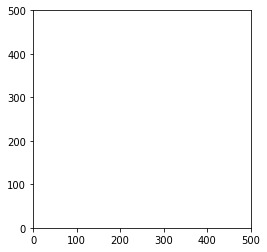

In [0]:
# prepare to animate
from matplotlib import animation
from IPython.display import HTML

# First we create the empty figure which we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 500))
ax.set_ylim((0, 500))

frame = ax.imshow(np.asarray(255*np.ones((500,500,3)),dtype=np.uint8))

def init():
    frame.set_data(np.asarray(255*np.ones((500,500,3)),dtype=np.uint8))
    return (frame,)

In [0]:

# get the display started to view the gym in colab
#display = Display(visible=0, size=(400, 300))
#display.start()
#screens=np.ones((500,500,3,20),dtype=np.uint8)


# Set hyper parameters.
EPISODE = 200
MAX_COUNTER = 200
CAPACITY = 100000
LEVEL = -1
MODEL = "model"
AGENT = "agent"

# Set the controller variables.
T = 50
n = 3
m = 1
x = cp.Variable((n, T+1))
u = cp.Variable((m, T))

s0 = np.asarray([[1.0], [0.0], [0.0]])
a0 = np.asarray([[0.0]])
beta = np.asarray([1.0, 1.0, 0.1])

A = cp.Parameter((n, n))
B = cp.Parameter((n, m))
x0 = cp.Parameter((n))
u0 = cp.Parameter((m))

# Loop on the horizon.
cost = 0
constr = []

for t in range(T):

	# Add the cost.
	cost += cp.sum_squares( (x[:,t+1] + x0 - s0[:,0]) * beta ) + cp.sum_squares( 0.001 * u[:,t])

	# Set the constraint.
	constr += [x[:,t+1] == A * x[:,t] + B[:,0] * u[:,t],
	cp.norm(u[:,t] + u0, "inf") <= 2.0]

# Set the initial constraint.
constr += [ x[:,0] == 0]

# Build the problem.
problem = cp.Problem(cp.Minimize(cost), constr)

# -------------------------------------------- #

def controller(x1=None, u1=None, A=None, B=None, new=True):
	"""
	"""

	# Solve the problem.
	problem.solve(warm_start=True)

	return u[:,0].value.reshape(-1,1) #+ u0.reshape(-1,1)

# -------------------------------------------- #


# Make the gym environment.
env = gym.make("Pendulum-v0")

# Get the environment action space.
action_space = env.action_space.shape[0]
state_space = env.observation_space.shape[0]

# Get the memory.
memory = Memory(CAPACITY)

# Get the predictor.
predictor = Predictor(state_space, action_space, hidden=128)

# Load the trainer.
agent = Agent(predictor, memory)

# Load a pretrained model.
try:
  agent.load(AGENT, MODEL)
except:
  print("Unable to load the agent.")

# Load the writer.
number = int( time.time() % ( 3600 * 24 ))
writer = SummaryWriter("tensorboard/runs_{}".format(number))

# Set the global counter.
global_counter = 0
verbose = False

# Perform a number of episodes.
for i_episode in range(EPISODE):

  # Reset the environment.
  state = env.reset()
  state = state.reshape(-1, 1)

  # Set the done flag.
  done = False

  # Set the initial counter.
  counter = 0
  action = a0
  
  # show the environment
  #prev_screen = env.render(mode='rgb_array')
  #plt.imshow(prev_screen)
  
  # Step on the environment while not done.
  while not done:

    # Render the environment.
    # env.render()

    # Linearise.
    A_new, B_new = predictor.linearise(state, action, diff=True)

    # Get the controller action.
    if i_episode > LEVEL:
      control_action = True
    else:
      control_action = False

    # Controller.
    if control_action is True:
      t_a = time.time()

      x0.value = state[:,0]
      u0.value = action[:,0]
      A.value = A_new
      B.value = B_new

      #action = controller()

      if counter == 0:
        problem.solve()
      else:
        #print(A.value)
        #print(B.value)
        problem.solve(solver=cp.SCS, warm_start=True)
      problem_value_print="optimal value with CVXOPT: {}".format(problem.value)

      action = (u[:,0].value + u0.value).reshape(-1, 1)

      state_print="{}".format(state)
      action_print="{}".format(action)   

      t_b = time.time()
      time_print="Elapsed time = {}".format(t_b - t_a)
    else:
      action = env.action_space.sample()
      action = action.reshape(-1, 1)

    # Step on the environment.
    next_state, reward, done, info = env.step(action)
    next_state  = next_state.reshape(-1, 1)

    # Push the results to the memory.
    memory.push(
      torch.Tensor(state), 
      torch.Tensor(action), 
      torch.Tensor(next_state),
      None)

    # Update the next state.
    state = next_state

    # Increment the counter.
    counter += 1
    global_counter += 1

    # Check the counter.
    if counter > MAX_COUNTER:
      break

    # Display.
    '''
    screens[:,:,:,(counter % 20)-1] = env.render(mode='rgb_array')
    if counter % 20 == 0:
      def animate(i):
        frame.set_data(screens[:,:,:,i])
        return (frame,)
      anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=20, interval=20, 
                               blit=True)
      HTML(anim.to_html5_video())
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())
    '''
    if counter % 20 == 0:
      print(problem_value_print)  
      print(state_print)   
      print(action_print)
      print(time_print)
      print("counter = {}".format(counter))

    # Train the model.
    if len(memory) > agent.BATCH_SIZE:

      # Get the old perf.
      C_old = agent.model_performance()

      # Perform one optimisation step.
      loss = agent.optimize()

      # Get the new perf.
      C_new = agent.model_performance()

      # Add the memory performance.
      writer.add_scalar("C",
        math.log(C_new / (C_old + 1.0e-8)), 
        global_counter)

      # Add the pnorm.
      writer.add_scalar("pnorm",
        agent.model_parameter_norm(), 
        global_counter)

      # Display the message.
      if loss is not None and verbose is True and counter % 20 == 0:
        msg = []
        msg.append("episode = {}".format(i_episode))
        msg.append("counter = {}".format(counter))
        msg.append("loss = {}".format(loss))
        print(", ".join(msg))

      # Record to the writer.
      if loss is not None and verbose is True:
        writer.add_scalar("loss",
          loss, global_counter)
        writer.add_scalar("log_loss", 
          math.log(loss), global_counter)

  # Save the agent's model.
  agent.save(AGENT, MODEL)

# Close the environment.
ipythondisplay.clear_output(wait=True)
env.close()



optimal value with CVXOPT: 0.024327572958876453
[[ 0.99591513]
 [-0.09029426]
 [ 0.71434764]]
[[1.99995867]]
Elapsed time = 0.49361658096313477
counter = 20
optimal value with CVXOPT: 67.62992900461701
[[ 0.1130932 ]
 [-0.99358438]
 [ 7.17221104]]
[[2.00034355]]
Elapsed time = 0.4855687618255615
counter = 40
optimal value with CVXOPT: 0.2362276367799736
[[ 0.90301767]
 [-0.42960341]
 [ 6.08316965]]
[[1.74766372]]
Elapsed time = 0.5818595886230469
counter = 60
optimal value with CVXOPT: 13.140404307343266
[[0.9919026 ]
 [0.12700093]
 [3.93841791]]
[[-1.99999965]]
Elapsed time = 0.5212640762329102
counter = 80
optimal value with CVXOPT: 0.6886201486338086
[[0.99995959]
 [0.00898949]
 [4.96132384]]
[[-1.99991948]]
Elapsed time = 0.5024371147155762
counter = 100
optimal value with CVXOPT: 13.944639409000832
[[0.99069048]
 [0.13613369]
 [4.01247424]]
[[-2.0000094]]
Elapsed time = 0.5004327297210693
counter = 120
optimal value with CVXOPT: 16.225198630058138
[[0.99582757]
 [0.09125482]
 [4.8

In [0]:
# ------------- #
# -- Figure --- #
# ------------- #


fig, ax = plt.subplots(2, sharex=True)
style = {"linewidth":0.75, "marker":".", "markersize":2.0}
ax[0].plot(obs[:,0], color="r", **style)
ax[0].grid()
ax[1].plot(obs[:,1], color="r", **style)	
ax[1].grid()
#ax[2].plot(obs[:,2], color="r", **style)	
#ax[2].grid()
#ax[3].plot(obs[:,3], color="r", **style)	
#ax[3].grid()		
plt.show()
plt.close("all")

NameError: ignored